# 📚 Character Network Analysis
This notebook is a step-by-step replication and expansion of the `character-network` GitHub project by Ken Huang. It follows the Digital Humanities 101 project instructions for code replication.

In [1]:
import os
import json
import codecs
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from afinn import Afinn
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from collections import Counter


In [19]:
def common_words(path):
    with codecs.open(path) as f:
        words = f.read()
        words = json.loads(words)

    return set(words)

def flatten(input_list):
    flat_list = []
    for i in input_list:
        if type(i) == list:
            flat_list += flatten(i)
        else:
            flat_list += [i]

    return flat_list

def read_novel(book_name, path):
    book_list = os.listdir(path)
    book_list = [i for i in book_list if i.find(book_name) >= 0]
    novel = ''
    for i in book_list:
        with codecs.open(path / i, 'r', encoding='utf-8', errors='ignore') as f:
            data = f.read().replace('\r', ' ').replace('\n', ' ').replace("\'", "'")
        novel += ' ' + data

    return novel

def name_entity_recognition(sentence):
    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON', 'ORG']]
    # convert all names to lowercase and remove 's in names
    name_entity = [str(x).lower().replace("'s","") for x in name_entity]
    # split names into single words ('Harry Potter' -> ['Harry', 'Potter'])
    name_entity = [x.split(' ') for x in name_entity]
    # flatten the name list
    name_entity = flatten(name_entity)
    # remove name words that are less than 3 letters to raise recognition accuracy
    name_entity = [x for x in name_entity if len(x) >= 3]
    # remove name words that are in the set of 4000 common words
    name_entity = [x for x in name_entity if x not in words]

    return name_entity

def iterative_NER(sentence_list, threshold_rate=0.0005):
    output = []
    for i in sentence_list:
        name_list = name_entity_recognition(i)
        if name_list != []:
            output.append(name_list)
    output = flatten(output)
    from collections import Counter
    output = Counter(output)
    output = [x for x in output if output[x] >= threshold_rate * len(sentence_list)]

    return output

def top_names(name_list, novel, top_num=20):
    vect = CountVectorizer(vocabulary=name_list, stop_words='english')
    name_frequency = vect.fit_transform([novel.lower()])
    name_frequency = pd.DataFrame(name_frequency.toarray(), columns=vect.get_feature_names_out())
    name_frequency = name_frequency.T
    name_frequency = name_frequency.sort_values(by=0, ascending=False)
    name_frequency = name_frequency[0:top_num]
    names = list(name_frequency.index)
    name_frequency = list(name_frequency[0])

    return name_frequency, names

def calculate_align_rate(sentence_list):
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    align_rate = np.sum(sentiment_score)/len(np.nonzero(sentiment_score)[0]) * -2

    return align_rate

def calculate_matrix(name_list, sentence_list, align_rate):
    afinn = Afinn()
    sentiment_score = [afinn.score(x) for x in sentence_list]
    # calculate occurrence matrix and sentiment matrix among the top characters
    name_vect = CountVectorizer(vocabulary=name_list, binary=True)
    occurrence_each_sentence = name_vect.fit_transform(sentence_list).toarray()
    cooccurrence_matrix = np.dot(occurrence_each_sentence.T, occurrence_each_sentence)
    sentiment_matrix = np.dot(occurrence_each_sentence.T, (occurrence_each_sentence.T * sentiment_score).T)
    sentiment_matrix += align_rate * cooccurrence_matrix
    cooccurrence_matrix = np.tril(cooccurrence_matrix)
    sentiment_matrix = np.tril(sentiment_matrix)
    # diagonals of the matrices are set to be 0 (co-occurrence of name itself is meaningless)
    shape = cooccurrence_matrix.shape[0]
    cooccurrence_matrix[[range(shape)], [range(shape)]] = 0
    sentiment_matrix[[range(shape)], [range(shape)]] = 0

    return cooccurrence_matrix, sentiment_matrix

def matrix_to_edge_list(matrix, mode, name_list):
    edge_list = []
    shape = matrix.shape[0]
    lower_tri_loc = list(zip(*np.where(np.triu(np.ones([shape, shape])) == 0)))
    normalized_matrix = matrix / np.max(np.abs(matrix))
    if mode == 'co-occurrence':
        weight = np.log(2000 * normalized_matrix + 1) * 0.7
        color = np.log(2000 * normalized_matrix + 1)
    if mode == 'sentiment':
        weight = np.log(np.abs(1000 * normalized_matrix) + 1) * 0.7
        color = 2000 * normalized_matrix
    for i in lower_tri_loc:
        edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))

    return edge_list


def plot_graph(name_list, name_frequency, matrix, plt_name, mode, path=''):
    label = {i: i for i in name_list}
    edge_list = matrix_to_edge_list(matrix, mode, name_list)
    normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

    plt.figure(figsize=(20, 20))
    G = nx.Graph()
    G.add_nodes_from(name_list)
    G.add_edges_from(edge_list)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = [G[u][v]['color'] for u, v in edges]

    if mode == 'co-occurrence':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000, edge_cmap=plt.cm.Blues,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True, width=weights)
    elif mode == 'sentiment':
        nx.draw(G, pos, node_color='#A0CBE2', node_size=np.sqrt(normalized_frequency) * 4000,
                linewidths=10, font_size=35, labels=label, edge_color=colors, with_labels=True,
                width=weights, edge_vmin=-1000, edge_vmax=1000)
    else:
        raise ValueError("mode should be either 'co-occurrence' or 'sentiment'")

    plt.show()



In [12]:
nlp = spacy.load("en_core_web_sm")
words = common_words("common_words.txt")
print("Loaded spaCy model and common words.")

Loaded spaCy model and common words.


In [13]:
novel_name = "Harry Potter"
novel_folder = Path.cwd() / "novels"
novel = read_novel(novel_name, novel_folder)
print(novel[:1000])  # preview first 1000 characters

 Harry Potter and the Sorcerer's Stone  CHAPTER ONE  THE BOY WHO LIVED  Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.  Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.  The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear it if anyone found out about the Potters. Mr

In [14]:
sentence_list = sent_tokenize(novel)
print(f"Number of sentences: {len(sentence_list)}")
print("First 5 sentences:")
print(sentence_list[:5])

Number of sentences: 91514
First 5 sentences:
[" Harry Potter and the Sorcerer's Stone  CHAPTER ONE  THE BOY WHO LIVED  Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.", "They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.", 'Mr. Dursley was the director of a firm called Grunnings, which made drills.', 'He was a big, beefy man with hardly any neck, although he did have a very large mustache.', 'Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors.']


In [15]:
align_rate = calculate_align_rate(sentence_list)
print(f"Alignment Rate: {align_rate}")

Alignment Rate: 0.28030668596858077


In [16]:
preliminary_name_list = iterative_NER(sentence_list)
print("Top recognized names (preliminary):", preliminary_name_list)

Top recognized names (preliminary): ['harry', 'potter', 'dursley', 'dursleys', 'dudley', 'albus', 'dumbledore', 'mcgonagall', 'pomfrey', 'lily', 'james', 'vernon', 'marge', 'petunia', 'figg', 'yeh', 'don', 'hogwarts', 'gringotts', 'cornelius', 'fudge', 'bathilda', 'magical', 'tom', 'quirrell', 'diagon', 'griphook', 'quidditch', 'madam', 'slytherin', 'hufflepuff', 'ollivander', 'ginny', 'percy', 'fred', 'george', 'ron', 'lee', 'jordan', 'weasley', 'charlie', 'grindelwald', 'neville', 'hermione', 'granger', 'muttered', 'ravenclaw', 'crabbe', 'goyle', 'malfoy', 'draco', 'weasleys', 'peeves', 'justin', 'gryffindor', 'dean', 'arts', 'snape', 'filch', 'hooch', 'gryffindors', 'norris', 'sprout', 'flitwick', 'charms', 'fang', 'thomas', 'slytherins', 'bin', 'severus', 'harry,', 'snitch', 'lavender', 'ron,', 'alicia', 'katie', 'firenze', 'voldemort', 'azkaban', 'arthur', 'prophet', 'mum', 'hogsmeade', 'stan', 'ernie', 'sirius', 'invisibility', 'firebolt', 'creatures', 'crookshanks', 'molly', 'lu

In [20]:
name_frequency, name_list = top_names(preliminary_name_list, novel, 25)
print("Top 25 character names:")
print(name_list)

Top 25 character names:
['harry', 'ron', 'hermione', 'dumbledore', 'snape', 'don', 'wand', 'weasley', 'malfoy', 'potter', 'voldemort', 'sirius', 'fred', 'hogwarts', 'lupin', 'george', 'neville', 'ginny', 'mcgonagall', 'umbridge', 'gryffindor', 'vernon', 'moody', 'fudge', 'dobby']


In [21]:
cooccurrence_matrix, sentiment_matrix = calculate_matrix(name_list, sentence_list, align_rate)
print("Co-occurrence and sentiment matrices calculated.")

Co-occurrence and sentiment matrices calculated.


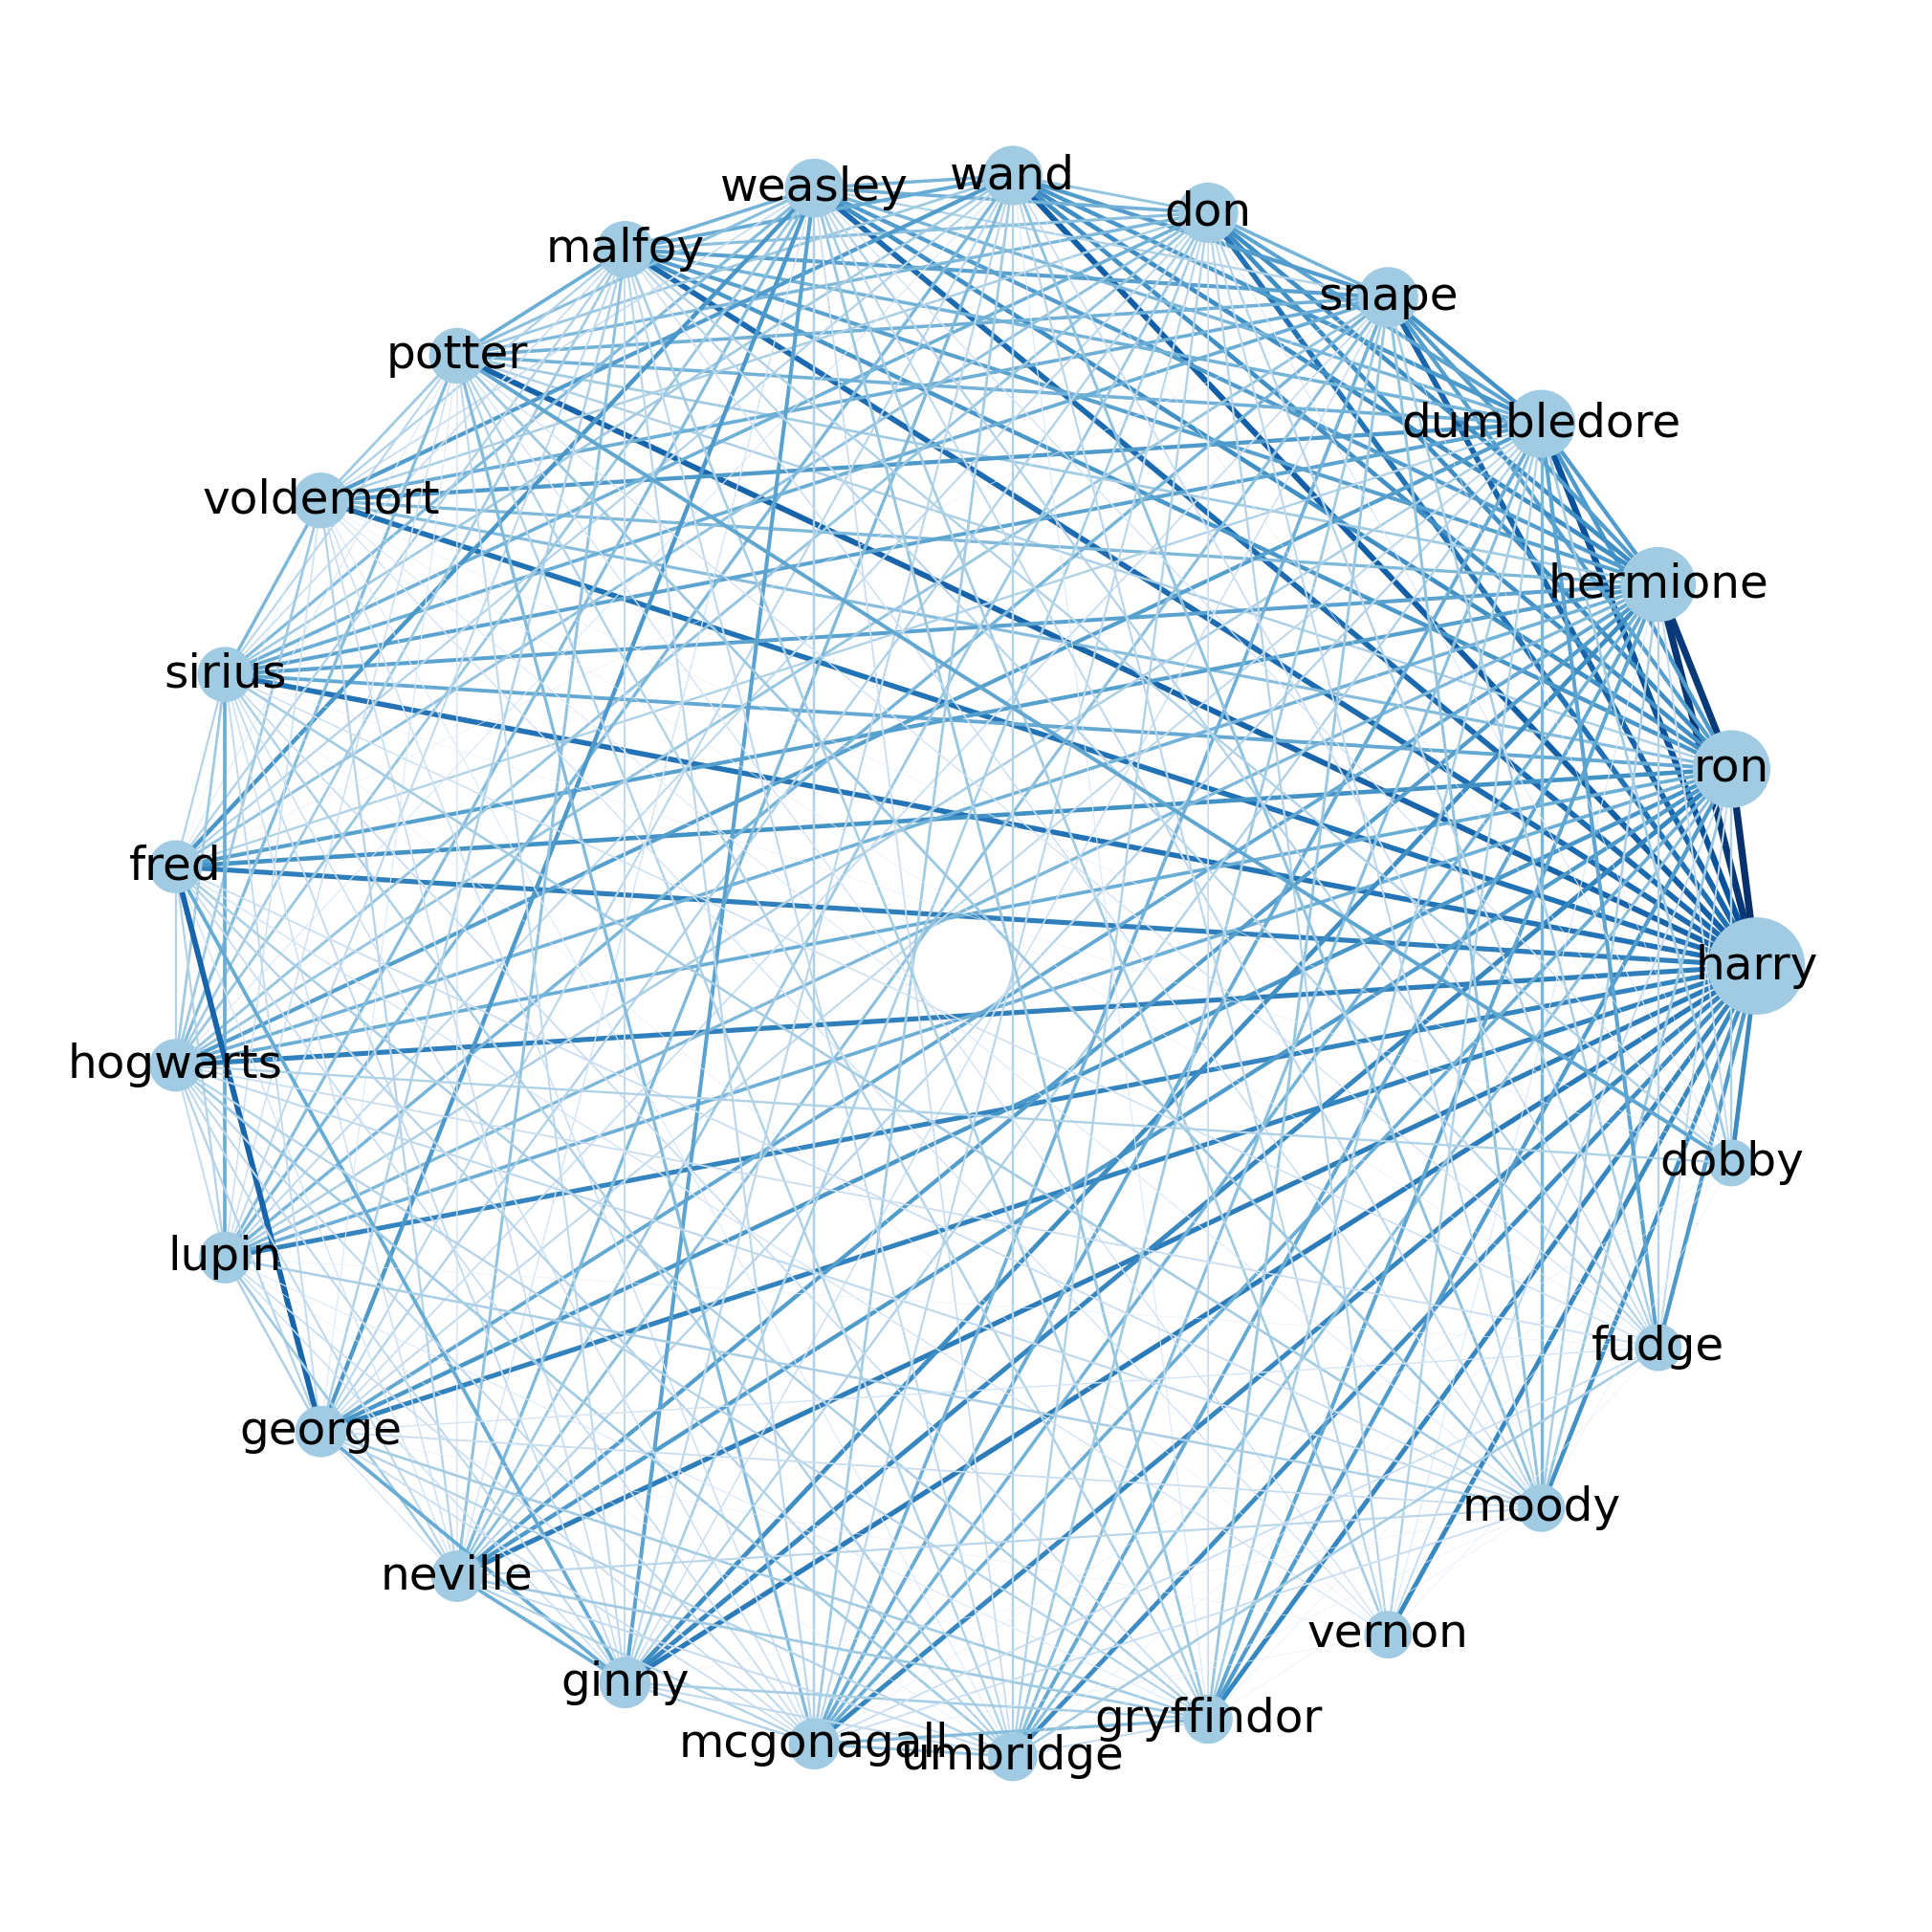

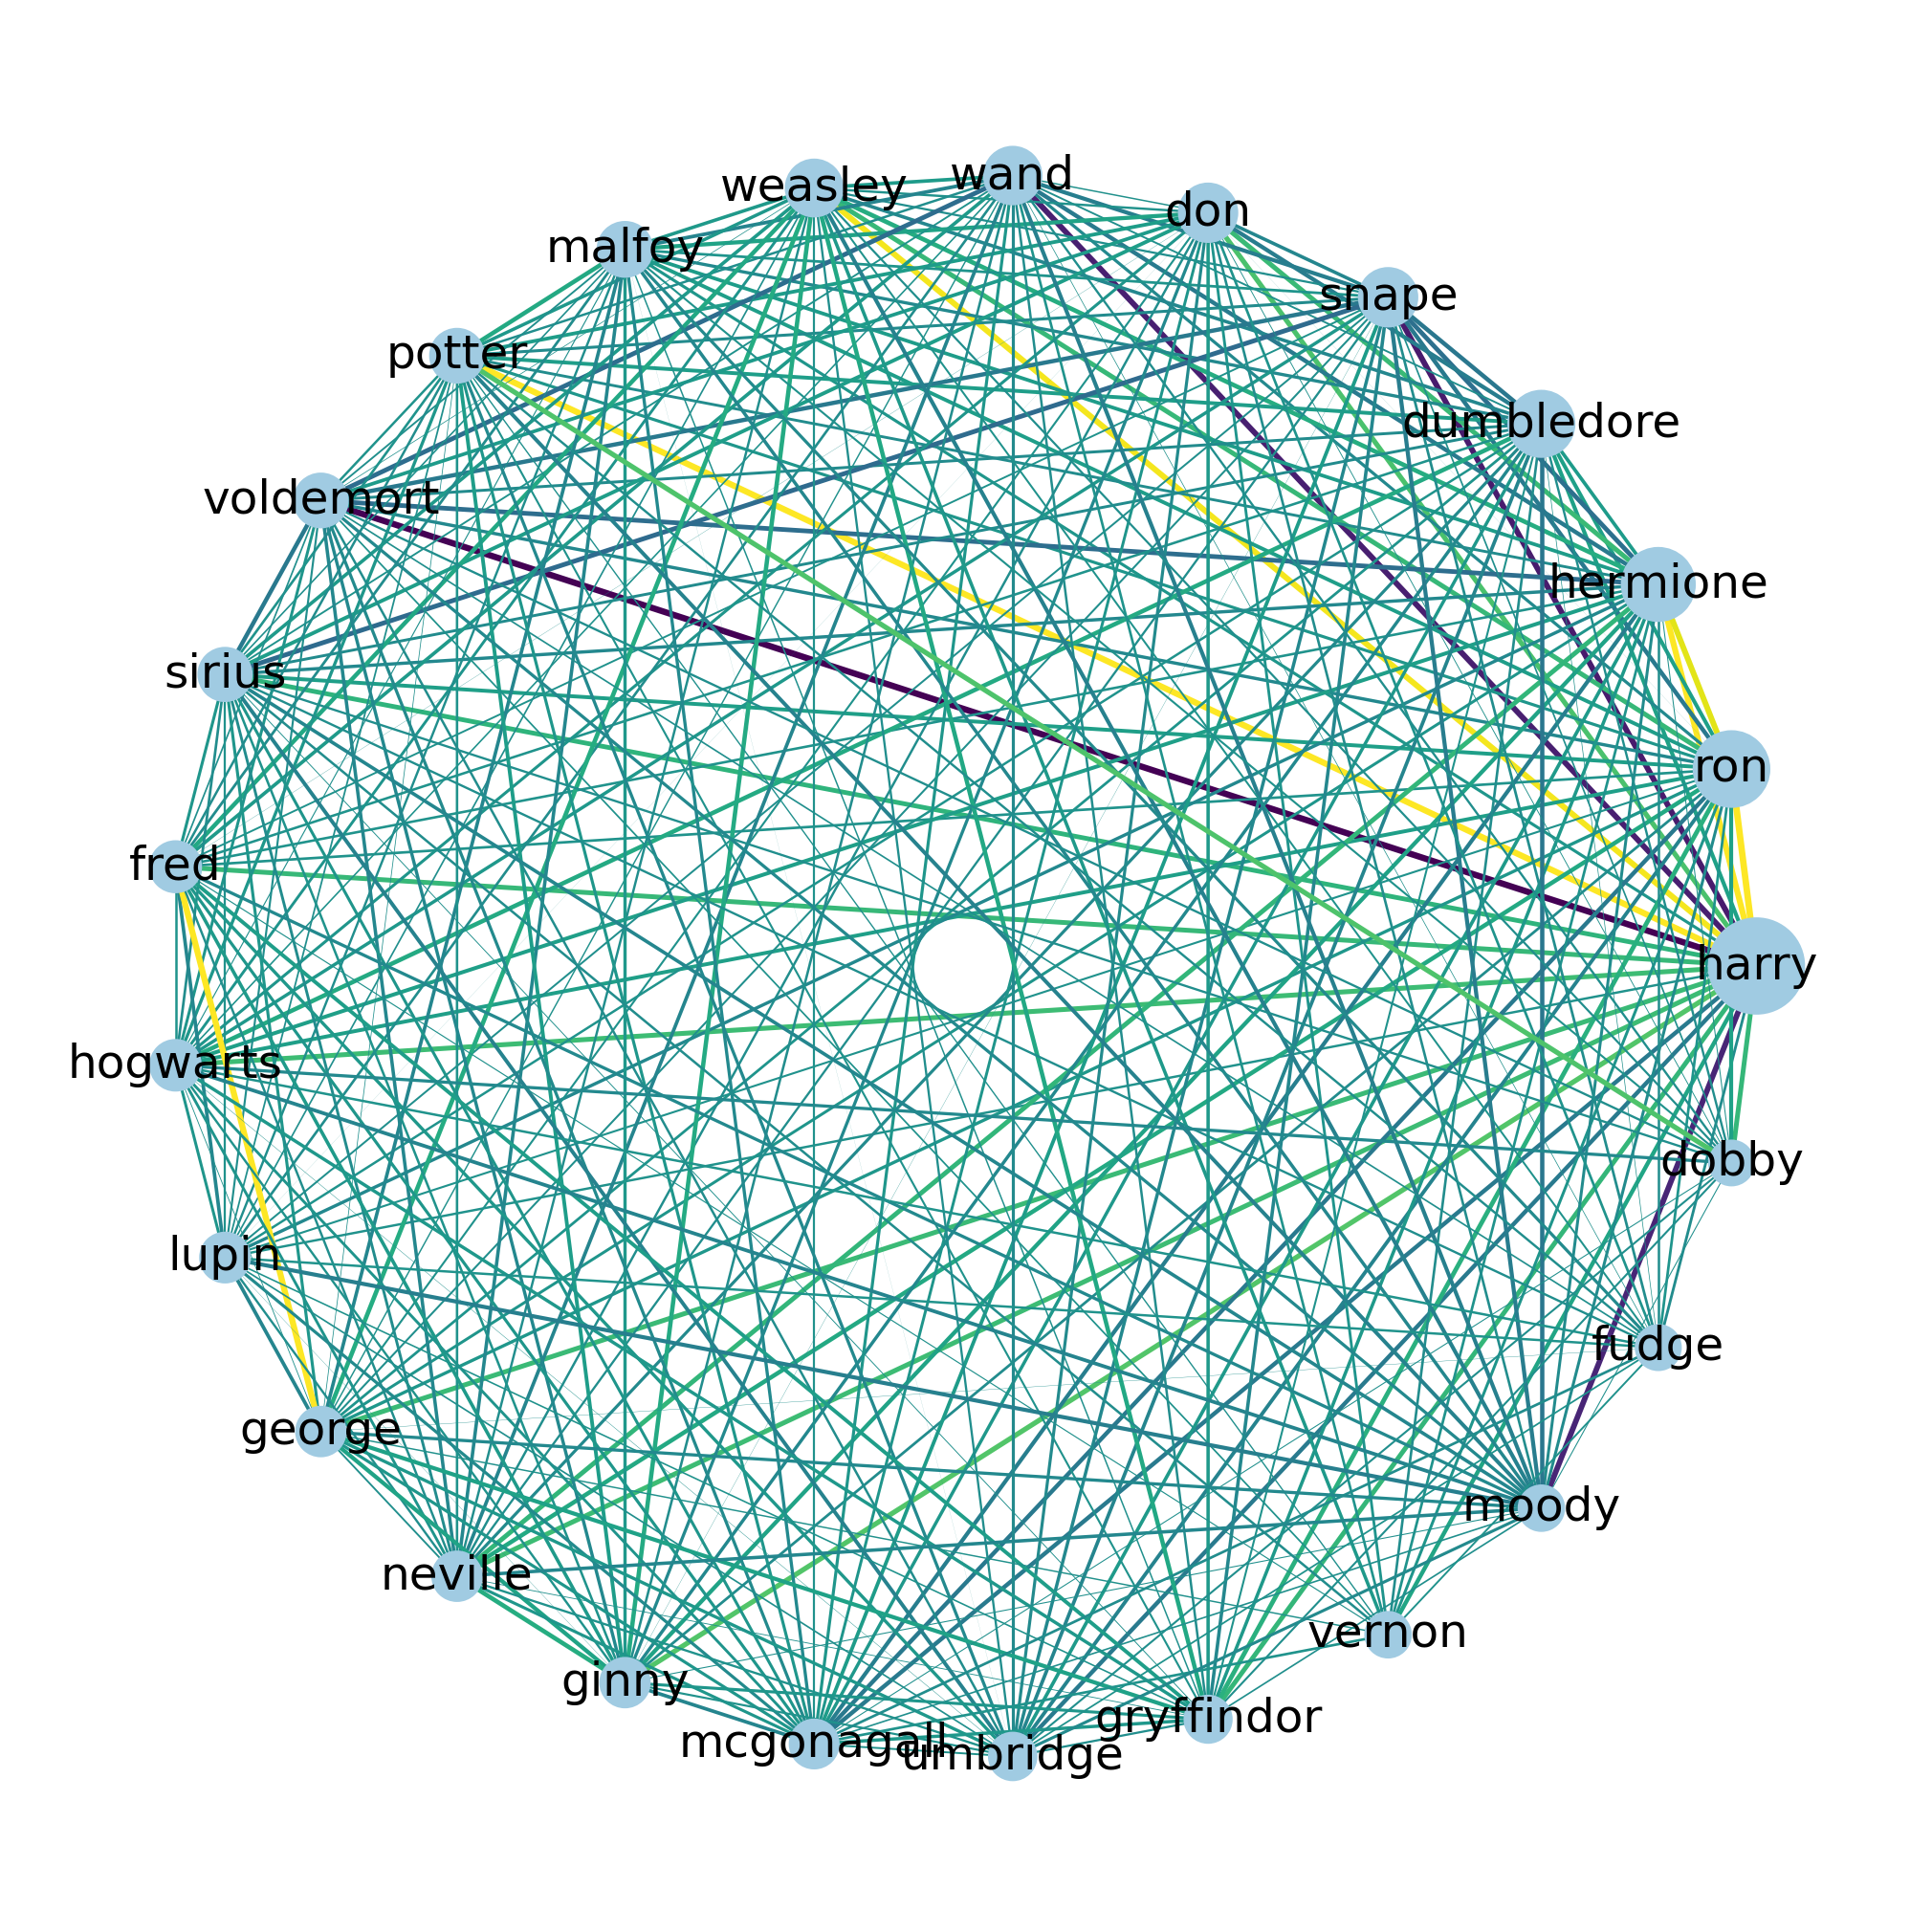

Graphs generated and saved.


In [22]:
plot_graph(name_list, name_frequency, cooccurrence_matrix, f"{novel_name}_cooccurrence", "co-occurrence")
plot_graph(name_list, name_frequency, sentiment_matrix, f"{novel_name}_sentiment", "sentiment")
print("Graphs generated and saved.")